Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


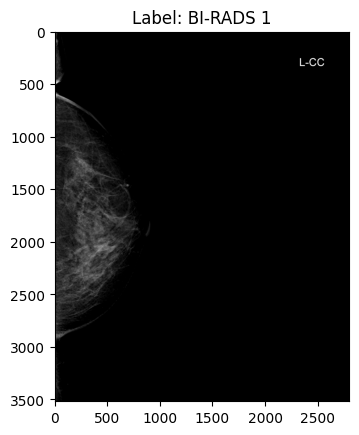

In [2]:
import os
import pydicom
import numpy as np
import cv2
import pandas as pd
import torch
from albumentations import Compose, Normalize
from pydicom.pixel_data_handlers.util import apply_voi_lut
from torch.utils.data import DataLoader, Dataset
import timm
from torchvision import transforms
import utils

# Ruta al dataset y al archivo CSV de anotaciones
dataset_path = '/Volumes/m2/Memoria/Datasets/Vincomprimido'
annotations_csv_path = '/Volumes/m2/Memoria/Datasets/Vincomprimido/metacomprimida.csv'

# Clase para cargar y preprocesar las imágenes DICOM
class MammoDataset(Dataset):
    def __init__(self, annotations_csv, dataset_path, transform=None):
        self.annotations = pd.read_csv(annotations_csv)
        self.dataset_path = dataset_path
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Obtener el series_id y image_id del archivo CSV
        series_id = self.annotations.iloc[idx]['study_id_x']
        image_id = self.annotations.iloc[idx]['image_id']
        
        # Construir la ruta al archivo DICOM
        dicom_path = os.path.join(self.dataset_path, series_id, f'{image_id}.dicom')
        
        # Cargar el archivo DICOM
        dicom = pydicom.dcmread(dicom_path)
        
        # Aplicar VOILUT si es necesario
        if 'VOILUTFunction' in dicom:
            image = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            image = dicom.pixel_array
        
        # Normalizar la imagen
        image = image.astype(np.float32)
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = (image * 255).astype(np.uint8)
        
        # Convertir a 3 canales (RGB)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        # Aplicar transformaciones si las hay
        if self.transform:
            image = self.transform(image=image)['image']
        
        # Obtener la etiqueta (si es necesario)
        label = self.annotations.iloc[idx]['breast_birads_x']
        
        return image, label

# Configuración de transformaciones
transform = Compose([
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, always_apply=True)
])

# Crear el dataset
dataset = MammoDataset(annotations_csv_path, dataset_path, transform=transform)

# Cargar una muestra para visualizar
image, label = dataset[20]



import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(f'Label: {label}')
plt.show()


Definí la clase MammoDataset para cargar y preprocesar las imágenes DICOM junto con sus anotaciones. Esta clase me permite manejar fácilmente las imágenes y sus etiquetas, además de aplicar transformaciones como la normalización y la conversión a RGB.

Configuré las transformaciones que aplico a las imágenes, específicamente una normalización para asegurar que los valores de los píxeles estén en un rango adecuado para el modelo.

Creé una instancia del dataset usando la clase MammoDataset, aplicando las transformaciones que configuré. Esto me permite acceder a las imágenes y sus etiquetas de manera estructurada.

Visualicé una de las imágenes del dataset junto con su etiqueta, cargándola y mostrándola usando matplotlib para asegurarme de que el preprocesamiento y las anotaciones están correctos.

In [3]:
# Ruta al archivo CSV
ruta_csv = "/Users/macdenico/PycharmProjects/PMM-FALP2024/Data Preprocessing/csv/metacomprimida.csv"

# Leer el archivo CSV y pasarlo a un DataFrame
df = pd.read_csv(ruta_csv)

df

,study_id_x,series_id_x,image_id,laterality_x,view_position_x,height_x,width_x,breast_birads_x,breast_density_x,split_x,...,Pixel Padding Value,Pixel Padding Range Limit,Window Center,Window Width,Rescale Intercept,Rescale Slope,Rescale Type,Window Center & Width Explanation,Manufacturer,Manufacturer's Model Name
0,2a2f500fb8edfd73f32cb8b4c5dfc860,9ca27167f9f1704a5d35165a79843ece,0a54e0e9fb46c39b3dba75eee808762c,L,CC,3518,2800,BI-RADS 1,DENSITY C,training,...,0,NaN,1667,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
1,2a2f500fb8edfd73f32cb8b4c5dfc860,9ca27167f9f1704a5d35165a79843ece,034d4806fba1ea27cb26a890364a30ce,L,MLO,3518,2800,BI-RADS 1,DENSITY C,training,...,0,NaN,1669,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
2,2a2f500fb8edfd73f32cb8b4c5dfc860,9ca27167f9f1704a5d35165a79843ece,900beae60194ff04165ae847794410a8,R,CC,3518,2800,BI-RADS 1,DENSITY C,training,...,0,NaN,1620,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
3,2a2f500fb8edfd73f32cb8b4c5dfc860,9ca27167f9f1704a5d35165a79843ece,47d025a81ac6097ecd5536fd0df56b9d,R,MLO,3518,2800,BI-RADS 1,DENSITY C,training,...,0,NaN,1655,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
4,16c3425e4c20fcfe1fa22a214c5f892b,6a03f02b9b6e286733a3a1d54738d7c3,71e047f902d28db333329bab9f7ae676,L,CC,3518,2800,BI-RADS 1,DENSITY C,training,...,0,NaN,1668,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,4b31fd58a3f25c683ffd9eb96c43245a,98e94fa329be0e713a96b0b5e1e499a1,cb3992b10ef27de6c2b735d792c58be0,R,CC,3580,2622,BI-RADS 3,DENSITY C,training,...,0,5874.0,"[12153, 12153, 12123, 12230, 12279]","[1529, 1529, 1376, 1681, 1681]",0,1,US,"['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...",IMS s.r.l.,GIOTTO CLASS
396,c85b5142b98887caddcf3649beba16bd,a7441896ca6bdfad2f2b195cbac0ab9d,299b526b6c6db3f31338bc961068b0f0,L,MLO,3580,2782,BI-RADS 1,DENSITY D,training,...,0,294.0,"[7523, 7523, 7487, 7614, 7672]","[1808, 1808, 1627, 1988, 1988]",0,1,US,"['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...",IMS s.r.l.,GIOTTO CLASS
397,c85b5142b98887caddcf3649beba16bd,a7441896ca6bdfad2f2b195cbac0ab9d,266faa805e6a022bc00f11dc89273d25,R,MLO,3580,2702,BI-RADS 1,DENSITY D,training,...,0,294.0,"[8488, 8488, 8461, 8558, 8603]","[1396, 1396, 1256, 1535, 1535]",0,1,US,"['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...",IMS s.r.l.,GIOTTO CLASS
398,c85b5142b98887caddcf3649beba16bd,a7441896ca6bdfad2f2b195cbac0ab9d,a02b584b659272f0114651d180a16219,R,CC,3580,2718,BI-RADS 1,DENSITY D,training,...,0,294.0,"[8572, 8572, 8545, 8642, 8686]","[1389, 1389, 1250, 1527, 1527]",0,1,US,"['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', ...",IMS s.r.l.,GIOTTO CLASS
